In [ ]:

from google.colab import files
import zipfile
import os

print(" Upload your puzzle dataset zip files...")
uploaded = files.upload()

# Extract all uploaded zip files
os.makedirs("dataset", exist_ok=True)

for zip_name in uploaded.keys():
    print(f" Extracting: {zip_name}")
    folder_name = zip_name.replace(".zip", "")
    extract_path = os.path.join("dataset", folder_name)
    os.makedirs(extract_path, exist_ok=True)

    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("\n Extraction complete! Folders in dataset/:")
print(os.listdir("dataset"))



📁 Upload your puzzle dataset zip files...


Saving correct.zip to correct.zip
Saving puzzle_2x2.zip to puzzle_2x2.zip
Saving puzzle_4x4.zip to puzzle_4x4.zip
Saving puzzle_8x8.zip to puzzle_8x8.zip
📦 Extracting: correct.zip
📦 Extracting: puzzle_2x2.zip
📦 Extracting: puzzle_4x4.zip
📦 Extracting: puzzle_8x8.zip

✅ Extraction complete! Folders in dataset/:
['puzzle_8x8', 'puzzle_4x4', 'correct', 'puzzle_2x2']


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import List, Tuple

✅ Loaded image: dataset/puzzle_2x2/puzzle_2x2/11.jpg | Shape: (224, 224, 3)


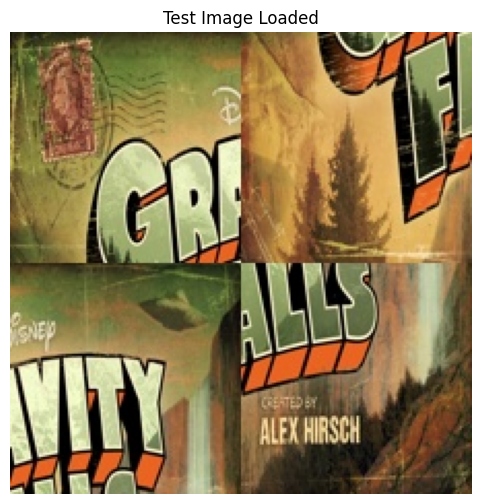

In [ ]:

# ============================================
# BLOCK 3: Utility - Load and Verify Image
# ============================================

def load_and_verify_image(path: str) -> np.ndarray:
    """Load image and verify it exists."""
    img = cv2.imread(path)
    if img is None:
        print(f" Error: Image not found at {path}")
        return None
    print(f" Loaded image: {path} | Shape: {img.shape}")
    return img

# Test this function

test_piece = load_and_verify_image("dataset/puzzle_2x2/puzzle_2x2/11.jpg")
if test_piece is not None:
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(test_piece, cv2.COLOR_BGR2RGB))  # ← correct
    plt.title("Test Image Loaded")
    plt.axis('off')
    plt.show()



In [ ]:

def split_into_grid(img: np.ndarray, rows: int, cols: int) -> List[Tuple[np.ndarray, int, int]]:
    """
    STEP 1: Split image into grid cells FIRST.
    Returns: List of (piece_image, row_index, col_index)
    """
    h, w = img.shape[:2]
    cell_h = h // rows
    cell_w = w // cols
    pieces = []

    for r in range(rows):
        for c in range(cols):
            y1, y2 = r * cell_h, (r + 1) * cell_h
            x1, x2 = c * cell_w, (c + 1) * cell_w

            piece = img[y1:y2, x1:x2]
            pieces.append((piece, r, c))

    return pieces



In [ ]:

def enhance_piece(piece: np.ndarray) -> np.ndarray:
    """
    STEP 2: Enhance individual piece using CLAHE.
    Returns: enhanced grayscale image
    """
    gray = cv2.cvtColor(piece, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    return enhanced


In [ ]:

def remove_background_v4(piece: np.ndarray) -> np.ndarray:
    """
    VERSION 4: Same logic as remove_background()
    Uses Adaptive Gaussian Thresholding to generate a binary mask.
    """
    gray = cv2.cvtColor(piece, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    binary = cv2.adaptiveThreshold(
        blurred,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        35,
        5
    )

    # Invert at the end (same as original)
    mask = cv2.bitwise_not(binary)
    return mask

def remove_background(img):
    return remove_background_v4(img)


'''
def remove_background_v4(piece: np.ndarray) -> np.ndarray:
    """
    VERSION 4: No Background Removal
    Treats entire piece as foreground (best for clean rectangular pieces).
    """
    h, w = piece.shape[:2]
    # Full white mask - entire piece is foreground
    mask = np.ones((h, w), dtype=np.uint8) * 255
    return mask

    '''

'\ndef remove_background_v4(piece: np.ndarray) -> np.ndarray:\n    """\n    VERSION 4: No Background Removal\n    Treats entire piece as foreground (best for clean rectangular pieces).\n    """\n    h, w = piece.shape[:2]\n    # Full white mask - entire piece is foreground\n    mask = np.ones((h, w), dtype=np.uint8) * 255\n    return mask\n\n    '

In [ ]:

def detect_edges(img: np.ndarray, mask: np.ndarray = None) -> np.ndarray:
    """
    STEP 4: Detect edges using Canny edge detector.
    If mask provided, only detect edges within the mask.
    Returns: binary edge map
    """
    # Apply mask if provided
    if mask is not None:
        img = cv2.bitwise_and(img, img, mask=mask)

    # Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(img, (5, 5), 1.4)

    # Canny edge detection
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

    return edges



In [ ]:

def extract_edge_profile(piece: np.ndarray, side: str, depth: int = 5) -> np.ndarray:
    """
    STEP 5: Extract edge gradient profile for matching in MS2.
    Extracts from 'depth' pixels into the piece (not just boundary).

    side: 'top', 'bottom', 'left', 'right'
    depth: how many pixels deep to sample from edge
    Returns: 2D array of gradient values (depth x length)
    """
    gray = cv2.cvtColor(piece, cv2.COLOR_BGR2GRAY) if len(piece.shape) == 3 else piece
    h, w = gray.shape

    # Extract edge region (multiple rows/cols)
    if side == 'top':
        edge_region = gray[:depth, :]
    elif side == 'bottom':
        edge_region = gray[-depth:, :]
    elif side == 'left':
        edge_region = gray[:, :depth]
    elif side == 'right':
        edge_region = gray[:, -depth:]

    # Compute gradient magnitude in the edge region
    gradient_x = cv2.Sobel(edge_region, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(edge_region, cv2.CV_64F, 0, 1, ksize=3)
    gradient_mag = np.sqrt(gradient_x**2 + gradient_y**2)

    # Average across depth to get 1D profile
    if side in ['top', 'bottom']:
        profile = np.mean(gradient_mag, axis=0)
    else:  # left, right
        profile = np.mean(gradient_mag, axis=1)

    return profile


In [ ]:

def process_single_puzzle(img_path: str, rows: int, cols: int, output_dir: str):
    """
    Main processing pipeline:
    1. Split into grid
    2. Enhance each piece
    3. Remove background
    4. Edge detection
    5. Extract edge profiles
    """
    start_time = time.time()

    img = cv2.imread(img_path)
    if img is None:
        print(f" ERROR: Could not load {img_path}")
        return

    img_name = os.path.splitext(os.path.basename(img_path))[0]

    # Create output folders
    folders = ['enhanced', 'binary_masks', 'edges', 'pieces', 'edge_profiles']
    for folder in folders:
        os.makedirs(os.path.join(output_dir, folder), exist_ok=True)

    print(f"\n Processing: {img_name} ({rows}x{cols} grid)")

    # STEP 1: Split into pieces
    pieces = split_into_grid(img, rows, cols)
    print(f"   Step 1: Split into {len(pieces)} pieces")

    # STEP 2-5: Process each piece
    for piece_img, r, c in pieces:
        piece_name = f"{img_name}_r{r}c{c}"

        # Save original piece
        cv2.imwrite(os.path.join(output_dir, 'pieces', f'{piece_name}.png'), piece_img)

        # STEP 2: Enhancement
        enhanced = enhance_piece(piece_img)
        cv2.imwrite(os.path.join(output_dir, 'enhanced', f'{piece_name}_enhanced.png'), enhanced)

        # STEP 3: Background removal
        binary_mask = remove_background(piece_img)
        cv2.imwrite(os.path.join(output_dir, 'binary_masks', f'{piece_name}_mask.png'), binary_mask)

        # STEP 4: Edge detection
        edges = detect_edges(enhanced, mask=binary_mask)
        cv2.imwrite(os.path.join(output_dir, 'edges', f'{piece_name}_edges.png'), edges)

        # STEP 5: Extract edge profiles for MS2
        profiles = {}
        for side in ['top', 'bottom', 'left', 'right']:
            profiles[side] = extract_edge_profile(piece_img, side, depth=5)

        # Save edge profiles
        np.savez(os.path.join(output_dir, 'edge_profiles', f'{piece_name}_profiles.npz'),
                 top=profiles['top'],
                 bottom=profiles['bottom'],
                 left=profiles['left'],
                 right=profiles['right'])

    elapsed = time.time() - start_time
    print(f" Completed in {elapsed:.2f}s - Processed {len(pieces)} pieces")



🧪 TESTING PIPELINE - Demonstration for TA

📂 Loading test image: dataset/puzzle_2x2/puzzle_2x2/11.jpg
✅ Image loaded successfully | Shape: (224, 224, 3)

--- STEP 1: Split Image into Grid (2x2) ---
✓ Split into 4 pieces


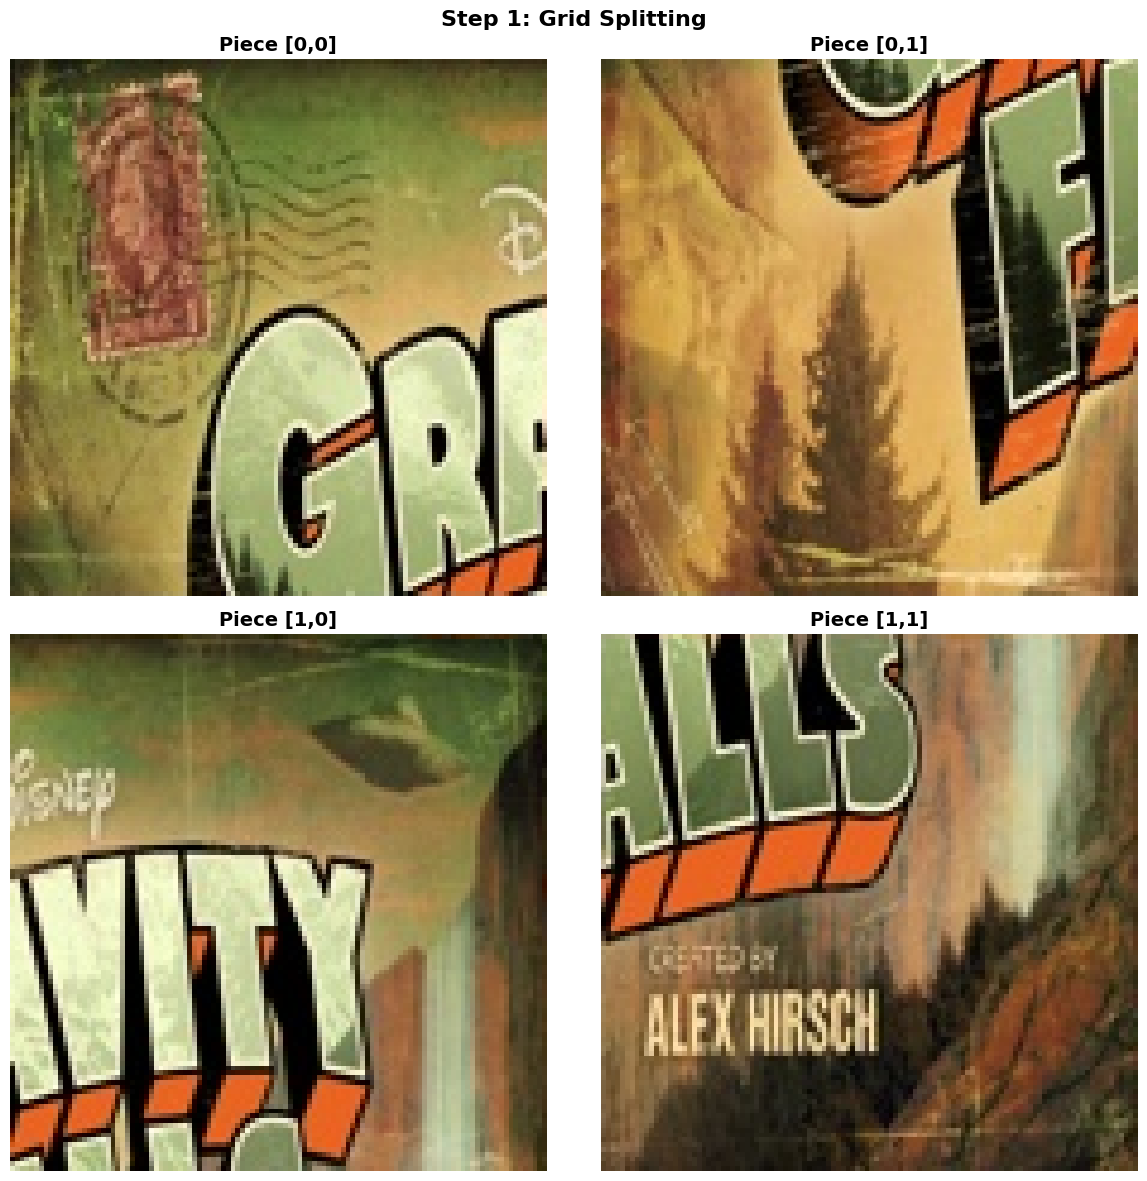


--- Processing First Piece Through Complete Pipeline ---
✓ Step 2: Enhancement complete
✓ Step 3: Background removal complete
✓ Step 4: Edge detection complete
✓ Step 5: Edge profile extraction complete

📊 Generating visualization for TA demonstration...


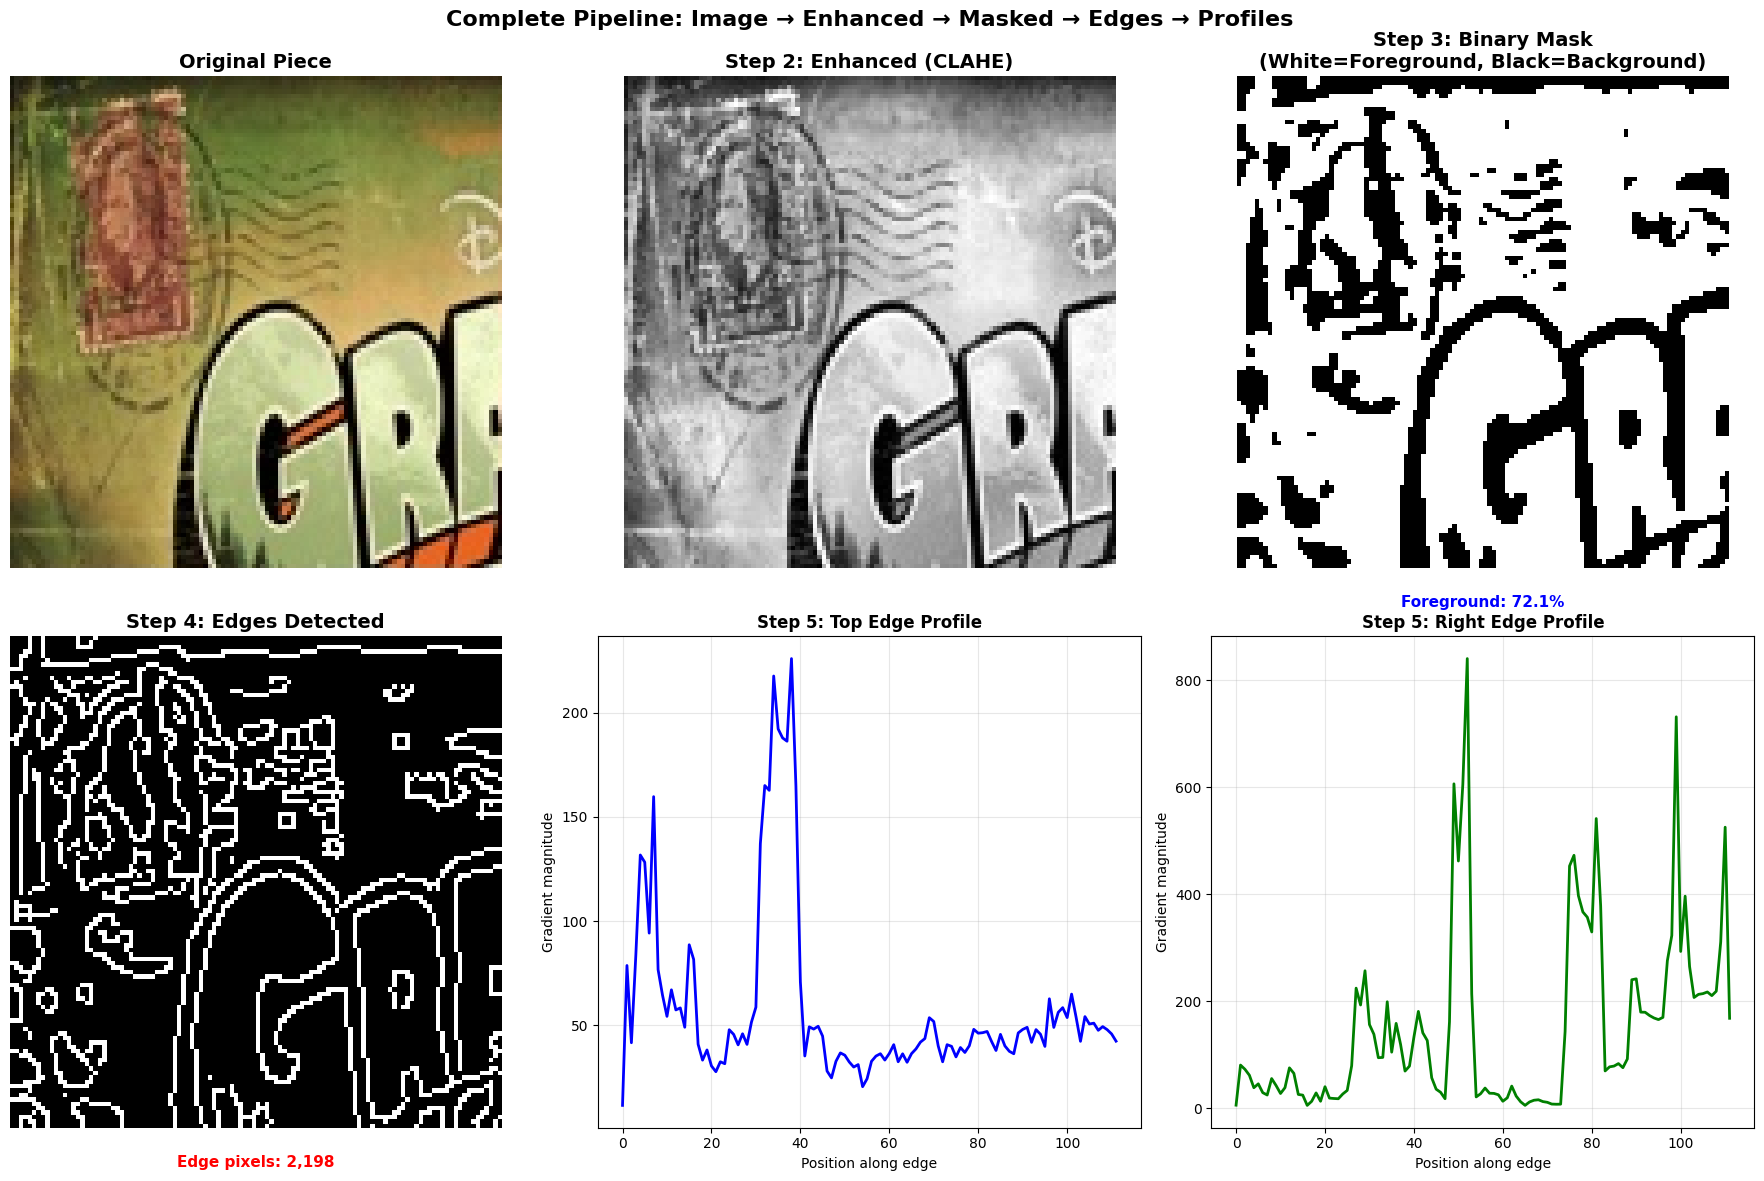


🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
✅ PIPELINE TEST COMPLETE - READY FOR TA DEMONSTRATION!
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉


In [ ]:

# ============================================
# BLOCK 3: TESTING - Show Pipeline Phases
# ============================================

print("\n" + "=" * 60)
print(" TESTING PIPELINE - Demonstration for TA")
print("=" * 60)

test_path = "dataset/puzzle_2x2/puzzle_2x2/11.jpg"

if os.path.exists(test_path):
    print(f"\n Loading test image: {test_path}")
    test_img = cv2.imread(test_path)

    if test_img is not None:
        print(f" Image loaded successfully | Shape: {test_img.shape}")

        # STEP 1: Split into grid
        print("\n--- STEP 1: Split Image into Grid (2x2) ---")
        pieces = split_into_grid(test_img, 2, 2)
        print(f"✓ Split into {len(pieces)} pieces")

        # Visualize grid split
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))
        for piece, r, c in pieces:
            ax = axes[r, c]
            ax.imshow(cv2.cvtColor(piece, cv2.COLOR_BGR2RGB))
            ax.set_title(f'Piece [{r},{c}]', fontsize=14, fontweight='bold')
            ax.axis('off')
        plt.suptitle('Step 1: Grid Splitting', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Use top-left piece for detailed pipeline demonstration
        test_piece = pieces[0][0]
        print("\n--- Processing First Piece Through Complete Pipeline ---")

        # STEP 2: Enhancement
        enhanced = enhance_piece(test_piece)
        print(" Step 2: Enhancement complete")

        # STEP 3: Background Removal
        binary_mask = remove_background_v4(test_piece)
        masked_piece = cv2.bitwise_and(test_piece, test_piece, mask=binary_mask)
        print(" Step 3: Background removal complete")

        # STEP 4: Edge Detection
        edges = detect_edges(enhanced, mask=binary_mask)
        print(" Step 4: Edge detection complete")

        # STEP 5: Edge Profile Extraction
        profiles = {}
        for side in ['top', 'bottom', 'left', 'right']:
            profiles[side] = extract_edge_profile(test_piece, side, depth=5)
        print(" Step 5: Edge profile extraction complete")

        # ============================================
        # VISUALIZATION: Complete Pipeline for TA
        # ============================================
        print("\n Generating visualization for TA demonstration...")

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Row 1: Main Pipeline Steps
        axes[0, 0].imshow(cv2.cvtColor(test_piece, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Original Piece', fontsize=14, fontweight='bold')
        axes[0, 0].axis('off')

        axes[0, 1].imshow(enhanced, cmap='gray')
        axes[0, 1].set_title('Step 2: Enhanced (CLAHE)', fontsize=14, fontweight='bold')
        axes[0, 1].axis('off')

        axes[0, 2].imshow(binary_mask, cmap='gray')
        axes[0, 2].set_title('Step 3: Binary Mask\n(White=Foreground, Black=Background)', fontsize=14, fontweight='bold')
        axes[0, 2].axis('off')
        white_pct = (np.sum(binary_mask == 255) / binary_mask.size) * 100
        axes[0, 2].text(0.5, -0.08, f'Foreground: {white_pct:.1f}%',
                        transform=axes[0, 2].transAxes,
                        ha='center', fontsize=11, color='blue', fontweight='bold')


        axes[1, 0].imshow(edges, cmap='gray')
        axes[1, 0].set_title('Step 4: Edges Detected', fontsize=14, fontweight='bold')
        axes[1, 0].axis('off')
        edge_count = np.sum(edges > 0)
        axes[1, 0].text(0.5, -0.08, f'Edge pixels: {edge_count:,}',
                        transform=axes[1, 0].transAxes,
                        ha='center', fontsize=11, color='red', fontweight='bold')

        # Row 2: Edge Profiles (Step 5)
        axes[1, 1].plot(profiles['top'], linewidth=2, color='blue')
        axes[1, 1].set_title('Step 5: Top Edge Profile', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Position along edge')
        axes[1, 1].set_ylabel('Gradient magnitude')
        axes[1, 1].grid(True, alpha=0.3)

        axes[1, 2].plot(profiles['right'], linewidth=2, color='green')
        axes[1, 2].set_title('Step 5: Right Edge Profile', fontsize=12, fontweight='bold')
        axes[1, 2].set_xlabel('Position along edge')
        axes[1, 2].set_ylabel('Gradient magnitude')
        axes[1, 2].grid(True, alpha=0.3)

        plt.suptitle('Complete Pipeline: Image → Enhanced → Masked → Edges → Profiles',
                     fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()

        print("\n" + "" * 30)
        print(" PIPELINE TEST COMPLETE - READY FOR TA DEMONSTRATION!")
        print("" * 30)

    else:
        print(" Failed to load image")
else:
    print(f"  Test image not found at: {test_path}")
    print("Please ensure puzzle_2x2 dataset is uploaded correctly")



In [ ]:

# ============================================
# BLOCK 4: Full Pipeline Execution
# ============================================

print("\n" + "=" * 60)
print(" RUNNING FULL PIPELINE ON ALL PUZZLES")
print("=" * 60)

OUTPUT_BASE = "processed_output"
os.makedirs(OUTPUT_BASE, exist_ok=True)

# Process all puzzle types
puzzle_configs = [
    ('dataset/puzzle_2x2/puzzle_2x2', 2, 2, 'puzzle_2x2'),
    ('dataset/puzzle_4x4/puzzle_4x4', 4, 4, 'puzzle_4x4'),
    ('dataset/puzzle_8x8/puzzle_8x8', 8, 8, 'puzzle_8x8'),
]

for dataset_path, rows, cols, puzzle_type in puzzle_configs:
    if not os.path.exists(dataset_path):
        print(f"\n  Skipping {puzzle_type}: folder not found")
        continue

    print(f"\n{'='*60}")
    print(f"Processing {puzzle_type} puzzles...")
    print(f"{'='*60}")

    output_dir = os.path.join(OUTPUT_BASE, puzzle_type)

    # Process all images in folder
    image_files = [f for f in os.listdir(dataset_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_file in sorted(image_files):
        img_path = os.path.join(dataset_path, img_file)
        process_single_puzzle(img_path, rows, cols, output_dir)

print("\n" + "=" * 60)
print(" ALL PROCESSING COMPLETE!")
print("=" * 60)
print(f" Output saved to: {OUTPUT_BASE}/")
print("\n Folder structure:")
print("  ├── pieces/         : Original puzzle pieces")
print("  ├── enhanced/       : CLAHE enhanced pieces")
print("  ├── binary_masks/   : Background removal masks")
print("  ├── edges/          : Edge detection results")
print("  └── edge_profiles/  : Gradient data for MS2 (.npz files)")
print("\ Ready for Milestone 2!")


🚀 RUNNING FULL PIPELINE ON ALL PUZZLES

Processing puzzle_2x2 puzzles...

📸 Processing: 0 (2x2 grid)
  ✓ Step 1: Split into 4 pieces
✅ Completed in 0.02s - Processed 4 pieces

📸 Processing: 1 (2x2 grid)
  ✓ Step 1: Split into 4 pieces
✅ Completed in 0.02s - Processed 4 pieces

📸 Processing: 10 (2x2 grid)
  ✓ Step 1: Split into 4 pieces
✅ Completed in 0.02s - Processed 4 pieces

📸 Processing: 100 (2x2 grid)
  ✓ Step 1: Split into 4 pieces
✅ Completed in 0.02s - Processed 4 pieces

📸 Processing: 101 (2x2 grid)
  ✓ Step 1: Split into 4 pieces
✅ Completed in 0.02s - Processed 4 pieces

📸 Processing: 102 (2x2 grid)
  ✓ Step 1: Split into 4 pieces
✅ Completed in 0.02s - Processed 4 pieces

📸 Processing: 103 (2x2 grid)
  ✓ Step 1: Split into 4 pieces
✅ Completed in 0.02s - Processed 4 pieces

📸 Processing: 104 (2x2 grid)
  ✓ Step 1: Split into 4 pieces
✅ Completed in 0.02s - Processed 4 pieces

📸 Processing: 105 (2x2 grid)
  ✓ Step 1: Split into 4 pieces
✅ Completed in 0.02s - Processed 4 pi


🔍 VERIFYING EDGE PROFILES

✅ Loading: processed_output/puzzle_2x2/edge_profiles/11_r0c0_profiles.npz

📊 Edge Profile Statistics:
  Top edge profile shape: (112,)
  Bottom edge profile shape: (112,)
  Left edge profile shape: (112,)
  Right edge profile shape: (112,)

🔢 Sample values from top edge:
  First 10 values: [ 11.6         78.69231031  41.64195332  83.86398528 131.69156956
 128.23283011  94.22956163 159.67419911  76.71880804  64.4111472 ]


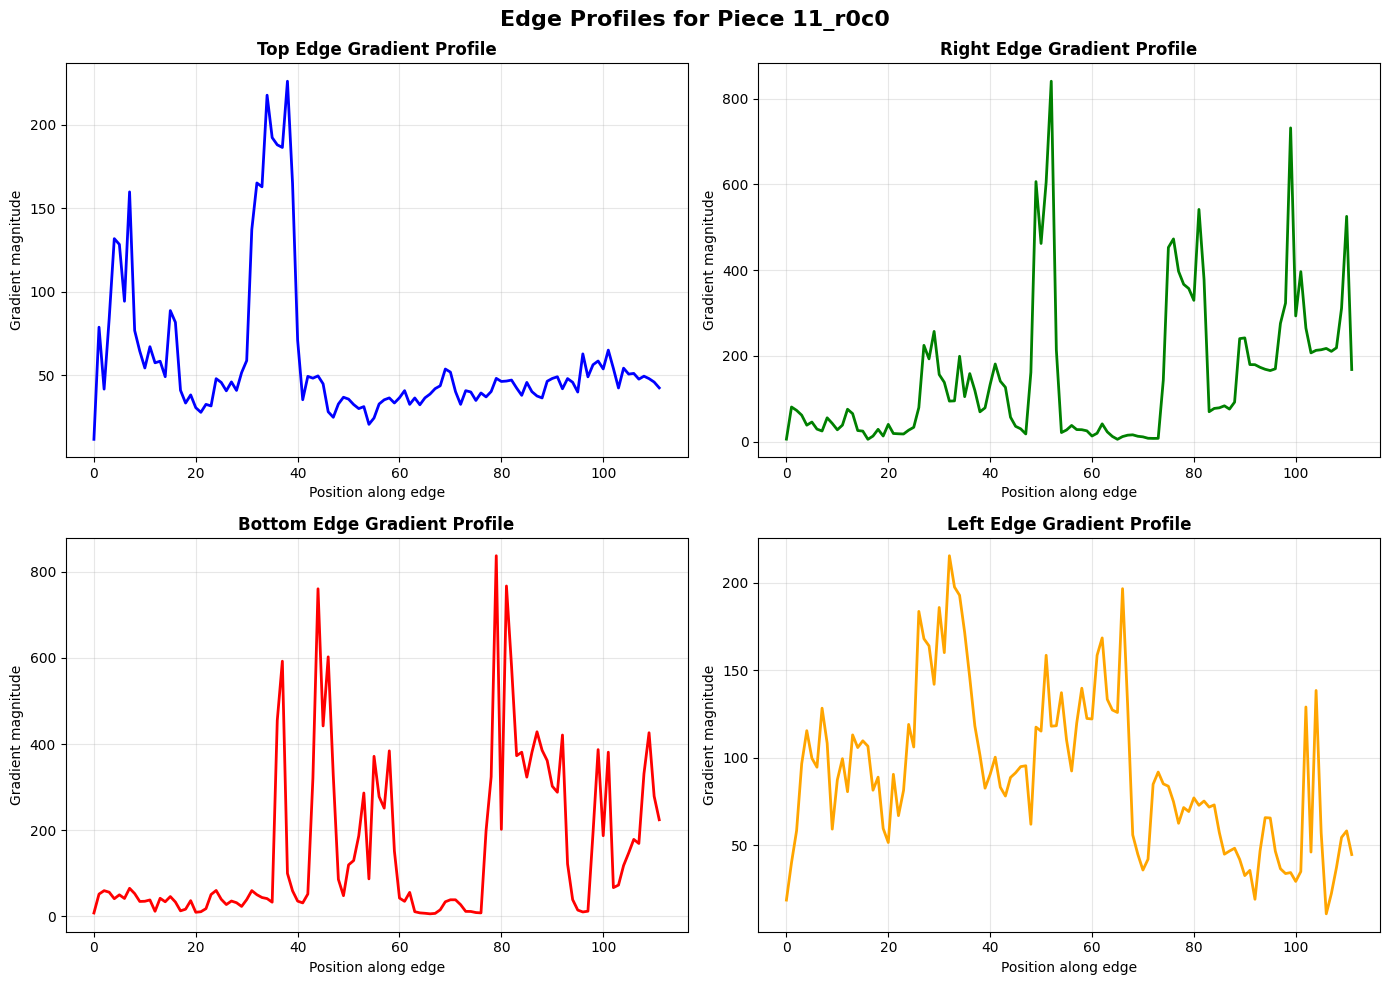


✅ Edge profiles loaded and visualized successfully!
🎯 These profiles will be used in Milestone 2 for edge matching


In [ ]:
# ============================================
# BLOCK 5: Verify Edge Profiles (Testing)
# ============================================

print("\n" + "=" * 60)
print(" VERIFYING EDGE PROFILES")
print("=" * 60)

# Load edge profiles for a piece
profile_path = 'processed_output/puzzle_2x2/edge_profiles/11_r0c0_profiles.npz'

if os.path.exists(profile_path):
    print(f"\n Loading: {profile_path}")

    profiles = np.load(profile_path)

    # Access individual edges
    top_edge = profiles['top']
    bottom_edge = profiles['bottom']
    left_edge = profiles['left']
    right_edge = profiles['right']

    # Print shapes
    print(f"\n Edge Profile Statistics:")
    print(f"  Top edge profile shape: {top_edge.shape}")
    print(f"  Bottom edge profile shape: {bottom_edge.shape}")
    print(f"  Left edge profile shape: {left_edge.shape}")
    print(f"  Right edge profile shape: {right_edge.shape}")

    print(f"\n Sample values from top edge:")
    print(f"  First 10 values: {top_edge[:10]}")

    # Plot all 4 profiles
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    axes[0, 0].plot(top_edge, 'b-', linewidth=2)
    axes[0, 0].set_title("Top Edge Gradient Profile", fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel("Position along edge")
    axes[0, 0].set_ylabel("Gradient magnitude")
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(right_edge, 'g-', linewidth=2)
    axes[0, 1].set_title("Right Edge Gradient Profile", fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel("Position along edge")
    axes[0, 1].set_ylabel("Gradient magnitude")
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].plot(bottom_edge, 'r-', linewidth=2)
    axes[1, 0].set_title("Bottom Edge Gradient Profile", fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel("Position along edge")
    axes[1, 0].set_ylabel("Gradient magnitude")
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(left_edge, color='orange', linewidth=2)
    axes[1, 1].set_title("Left Edge Gradient Profile", fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel("Position along edge")
    axes[1, 1].set_ylabel("Gradient magnitude")
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Edge Profiles for Piece 11_r0c0', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n Edge profiles loaded and visualized successfully!")
    print(" These profiles will be used in Milestone 2 for edge matching")

else:
    print(f"\n Profile file not found at: {profile_path}")
    print("Make sure to:")
    print("  1. Uncomment the np.savez() line in process_single_puzzle()")
    print("  2. Run BLOCK 4 to generate the profiles")